# Projeto 1 - Ciência dos Dados

Nome: Enzo Luidge

Nome: Thiago Teixeira

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\tynam\OneDrive\Documentos\Cdados\projeto 1


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [11]:
filename = 'Calamidade.xlsx'

In [12]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,não vai ter reprise hojeeeeeeeeee??? #calamidade,0
1,"agatha tá de novo visu, mas a linguinha já é m...",0
2,"o chat tá dizendo que vai ter, então vai ter n...",0
3,tive q fazer akkzkskkskak \ncarina conhecendo ...,0
4,a abertura de calamidade ta tao tao tao tao fo...,1


In [13]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Relevancia
0,#calamidade kkkkkkkkkkkkkkkkkkkkk carina mafio...,0
1,"reassistindo o episódio, anotando várias coisa...",0
2,spoilerzinha da minha oc de ordem paranormal 🤭...,0
3,avisa que são eles!!! #calamidadefanart #calam...,0
4,sobre #calamidade ninguém tá se perguntando qu...,0


___
## Classificador automático de sentimento


Nosso produto é a série de RPG Ordem Paranormal: Calamidade, que acontece aos sábados na Twitch, no canal Cellbit. Como essa temporada começou recentemente, atingindo mais de 120 mil espectadores ao vivo logo no primeiro episódio, achamos se tratar de um produto interessante para a classificação de tweets.

Classificação: nossa classificação foi feita considerando como "relevante" tweets que continham opiniões, reclamações e apontamentos sobre a série, classificando como "irrelevante" todo o resto.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [14]:
! pip install emoji
import emoji  #importando a biblioteca emoji para tratar os emojis dos tweets

In [15]:
def cleanup(text):
    
    text = emoji.demojize(text, delimiters=(' ',' ')) #ttransforma os emojis em palavras, sendo possível tratá-los
    text_subbed = "".join(u for u in text if u not in ("?", ".", ";", ":", "!",'"',"'","-","\n","#","(",")","[","]",","))
    stopwords = ['a','que','o','e','se','da','em','com', 'do','q', 'de','pra'] #para a limpeza das stopwords mais comuns
    
    text_subbed = text_subbed.split() #separa todas as palavras em uma lista
    
    text_list = []
    for i in text_subbed: 
        if not ('https' in i) and not ('@' in i) and not (i in stopwords): #exclui links, nomes de perfis e stopwords
            text_list.append(i)
    
    text_final = ' '.join(text_list) #junta as palavras separando por espaço, corrigindo espaços duplos
    return text_final.lower()

string = 'Hello World! I LOVE #CALAMIDADE,   HAHAHAHA\n YES 🤐🤐🤐'

print(cleanup(string))

hello world i love calamidade hahahaha yes zippermouth_face zippermouth_face zippermouth_face


In [16]:
#Conjunto de todas as palavras:
todas_palavras = ' '.join(train.Treinamento)
todas_palavras = cleanup(todas_palavras)
todas_palavras = todas_palavras.split()
serie_todas_palavras = pd.Series(todas_palavras)
tabela_todas_palavras = serie_todas_palavras.value_counts() #Sem normalizar os valores, para a suavização Laplace depois

#Conjunto de palavras dos Tweets relevantes:
relevantes = ' '.join(train.Treinamento[train.Relevancia==1])
relevantes = cleanup(relevantes)
relevantes = relevantes.split()
serie_relevantes = pd.Series(relevantes)
tabela_relevantes = serie_relevantes.value_counts()

#Conjunto de palavras dos Tweets irrelevantes:
irrelevantes = ' '.join(train.Treinamento[train.Relevancia==0])
irrelevantes = cleanup(irrelevantes)
irrelevantes = irrelevantes.split()
serie_irrelevantes = pd.Series(irrelevantes)
tabela_irrelevantes = serie_irrelevantes.value_counts()

***R***: Relevantes

***I***: Irrelevantes

In [17]:
probR = len(relevantes)/len(todas_palavras)
probI = len(irrelevantes)/len(todas_palavras)

probR+probI

1.0

In [18]:
def classificador(Tweet): #Função do classificador
    Tweet = cleanup(Tweet)
    
    probTweetDadoR = 1
    probTweetDadoI = 1

    for palavra in Tweet.split(): #Com suavização Laplace
        if palavra in relevantes:
            probTweetDadoR = probTweetDadoR*((tabela_relevantes[palavra]+1)/(len(tabela_relevantes)+len(tabela_todas_palavras)))
        else:
            probTweetDadoR = probTweetDadoR*(1/len(tabela_todas_palavras))


        if palavra in irrelevantes:
            probTweetDadoI = probTweetDadoI*((tabela_irrelevantes[palavra]+1)/(len(tabela_irrelevantes)+len(tabela_todas_palavras)))
        else:
            probTweetDadoI = probTweetDadoI*(1/len(tabela_todas_palavras))
            
    probRdadoTweet = probTweetDadoR*probR
    probIdadoTweet = probTweetDadoI*probI

    if probRdadoTweet > probIdadoTweet:
        return 1 #Relevante
    else:
        return 0 #Irrelevante

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [19]:
for tweet in test.Teste:
    if classificador(tweet) == 1:
        test.loc[test.Teste==tweet,'Classificador'] = 1
    else:
        test.loc[test.Teste==tweet,'Classificador'] = 0
    
v_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==1),:])/len(test))
v_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==0),:])/len(test))
f_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==0),:])/len(test))
f_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==1),:])/len(test))

print('Verdadeiros positivos: {0}%'.format(v_positivos*100))
print('Verdadeiros negativos: {0}%'.format(v_negativos*100))
print('Falsos positivos: {0}%'.format(f_positivos*100))
print('Falsos negativos: {0}%'.format(f_negativos*100))

print('Acurácia: {0}%'.format((v_positivos+v_negativos)*100))

Verdadeiros positivos: 12.5%
Verdadeiros negativos: 63.0%
Falsos positivos: 19.5%
Falsos negativos: 5.0%
Acurácia: 75.5%


___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [20]:
#Juntando os dois dataframes:
dados = train.append(test).reset_index()
Tweets = []
for tweet in train.Treinamento:
    Tweets.append(tweet)
    
for tweet in test.Teste:
    Tweets.append(tweet)

dados['Tweets'] = Tweets 
dados = dados.drop(['index','Classificador','Treinamento','Teste'], axis=1)

In [21]:
#Repetindo os items 3 a 4 para cada nova separação:
acertos = []
for i in range(100):
    test = dados.sample(frac = 0.60)
    train = dados.drop(test.index)

    #Conjunto de todas as palavras:
    todas_palavras = ' '.join(train.Tweets)
    todas_palavras = cleanup(todas_palavras)
    todas_palavras = todas_palavras.split()
    serie_todas_palavras = pd.Series(todas_palavras)
    tabela_todas_palavras = serie_todas_palavras.value_counts() #Sem normalizar os valores, para a suavização Laplace depois

    #Conjunto de palavras dos Tweets relevantes:
    relevantes = ' '.join(train.Tweets[train.Relevancia==1])
    relevantes = cleanup(relevantes)
    relevantes = relevantes.split()
    serie_relevantes = pd.Series(relevantes)
    tabela_relevantes = serie_relevantes.value_counts()

    #Conjunto de palavras dos Tweets irrelevantes:
    irrelevantes = ' '.join(train.Tweets[train.Relevancia==0])
    irrelevantes = cleanup(irrelevantes)
    irrelevantes = irrelevantes.split()
    serie_irrelevantes = pd.Series(irrelevantes)
    tabela_irrelevantes = serie_irrelevantes.value_counts()


    for tweet in test.Tweets:
        if classificador(tweet) == 1:
            test.loc[test.Tweets==tweet,'Classificador'] = 1
        else:
            test.loc[test.Tweets==tweet,'Classificador'] = 0

    v_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==1),:])/len(test))
    v_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==0),:])/len(test))
    acerto = v_positivos + v_negativos

    acertos.append(acerto)

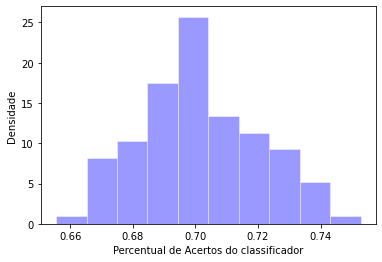

In [22]:
plt.hist(acertos, color='blue', edgecolor='white', alpha = 0.4, density=True)
plt.xlabel('Percentual de Acertos do classificador')
plt.ylabel('Densidade')
plt.show()

Dependendo da distibuição dos mesmos tweets entre a base de treinamento e a base de teste, o percentual de acerto do classificador flutua  em torno de um valor médio. Ao se usar apenas uma distribuição, essa flutuação de percentual é um obstáculo para avaliar a competência do classificador.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**